# -This notebook shows an experiment of taking the best model and running it for 300 epochs, to see if there is going to be an improvement after 100 epochs-

# Imports and data loading

In [1]:
######################################################################
############################# Imports ################################
######################################################################
import sys
import os
import uuid

import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import CustomObjectScope

import keras.backend as K
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.models import Model
from keras.models import load_model 
from keras.utils import Sequence
from keras.utils import load_img
from keras.callbacks import *

2023-01-29 01:00:45.253348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
######################################################################    
########################### Debug info ###############################    
######################################################################  
!nvidia-smi
tf.config.list_physical_devices('GPU')

Sun Jan 29 01:00:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   35C    P0    39W / 250W |  15102MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
######################################################################    
####################### Load refference data #########################    
######################################################################  
df = pd.read_csv('black_background_500x500.csv')
train_df = df[df['ImagePath'].str.contains("train")]
test_df = df[df['ImagePath'].str.contains("test")]
valid_df = df[df['ImagePath'].str.contains("valid")]

input_size = 500

In [4]:
######################################################################
############################ data generator ##########################
######################################################################
class datagenerator(tf.keras.utils.Sequence):
    def __init__(self, 
            batch_size, 
            img_size,
            data_paths_df,
            input_channels,
            output_channels):
         
        self.batch_size = batch_size
        self.img_size = img_size
        self.data_paths_df = data_paths_df
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.data_paths = data_paths_df.values[:,1]
        self.params = data_paths_df.values[:,3:6]
        assert len(self.data_paths) == len(self.params)
        
        self.n = len(self.data_paths)

    def on_epoch_end(self):
        'updates indexes after each epoch'
        self.data_paths_df = self.data_paths_df.sample(frac = 1)
        self.data_paths = self.data_paths_df.values[:,1]
        self.params = self.data_paths_df.values[:,3:6]
    
    def __getitem__(self, index):
        batch_data_paths = self.data_paths[index : index + self.batch_size]
        batch_params_paths = self.params[index : index + self.batch_size]

        return self.__dataloader(self.img_size,
                batch_data_paths, batch_params_paths,
                self.input_channels, self.output_channels)
    
    def __len__(self):
        return self.n // self.batch_size

    #################### data loader ########################
    def __dataloader(self, 
            img_size,
            data_paths,
            batch_params_paths,
            input_channels,
            output_channels):
        x = np.zeros((len(data_paths), img_size[0], img_size[1], input_channels))
        y = batch_params_paths        
        
        for i in range(len(data_paths)):
            data = load_img(path = data_paths[i], color_mode = "grayscale")
            data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
            data /= 255
            x[i] = np.asarray(data)
        return x.astype("float32"), np.array(y).astype("float32")

# Definitions of important functions

In [5]:
######################################################################    
########################## Loss functions ############################    
###################################################################### 
import keras.backend as K
  
def abs_loss_function(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    return tf.math.reduce_mean(minimum_from_two, axis=-1)

def square_abs_min_loss(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    min_sq = tf.math.sqrt(minimum_from_two)
    return tf.math.reduce_mean(min_sq, axis=-1) 

def smart_square_abs_min_loss(y_true, y_pred):  
    punished_y_pred = tf.where((y_pred<0)|(y_pred>1), 3.0 + K.abs(y_pred),y_pred)
    abs_diff = K.abs(y_true - punished_y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff)   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed)     
    return tf.math.reduce_mean(minimum_from_two, axis=-1)
    
############################# For debugging ####################################
#     print("_________________ 1 __________________")
#     print(abs_diff_reversed.numpy())
#     print("_________________ 2 __________________")
#     print(abs_diff.numpy())

In [12]:
######################################################################    
############## Callback function to print evaluation #################    
###################################################################### 
test_g = datagenerator(32, (input_size,input_size), test_df, 1, 3)
evaluation_list = []
accuracy_list = []
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 5 == 0:
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            m_e = self.model.evaluate(test_g, batch_size=32)
            for i in range(60):
                evaluation_list.append(m_e[0])
                accuracy_list.append(m_e[2])
            print("Loss on test data: ", m_e[0])
            for nr in range(3):
                t = test_df.values[nr][1]
                data = load_img(path = t, grayscale = True)
                data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
                data /= 255
                data.shape = (1,) + data.shape
                X = np.asarray(data)
                print("----------{}----------".format(nr))
                euler = t.split("_")
                print("phi1", float(euler[3]))
                print("PHI",   float(euler[4]))
                print("phi2",  float(euler[5][:-4]))
                yhat = model.predict(data)
                print("predicted values", yhat*90)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            model.save("TempModels/epoch{}.h5".format(epoch), save_format = 'h5')
            

# Experiment section

In [7]:
######################################################################
############################# Experiments ############################
######################################################################
def conv_block(x, filters, kernel_size, regul):
    if regul:
        biasregul = regularizers.l2(regul)
        kernelregul = regularizers.l2(regul)
    else:
        biasregul = kernelregul = None
    x = ReflectionPadding2D(padding=((kernel_size-1),
                                     (kernel_size-1)))(x)
    x = layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="valid",
            #activation=lambda x: activations.relu(x, alpha=0.1),
            kernel_initializer='RandomNormal',
            bias_initializer=initializers.Constant(0.1),
            kernel_regularizer=kernelregul,
            bias_regularizer=biasregul
            )(x)
    x = layers.PReLU(
            shared_axes=[1,2],
            alpha_initializer=tf.initializers.Constant(0.01),
            )(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation("relu")(x)
    #x = layers.Dropout(rate=0.5)(x)
    
    return x

In [8]:
######################################################################    
######################## Loading the model ###########################    
###################################################################### 
inputs = keras.Input(shape=(input_size, input_size, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(3)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 32)      9248      
                                                             

In [13]:
######################################################################    
##################### Compile and run the model ######################    
###################################################################### 
model.compile(optimizer = RMSprop(learning_rate=0.0005),
              loss = smart_square_abs_min_loss, 
              metrics = [smart_square_abs_min_loss, "accuracy"])  # Add run_eagerly=True to enable the numpy debugging

tg = datagenerator(32, (input_size,input_size), train_df, 1, 3)
vg = datagenerator(32, (input_size,input_size), valid_df, 1, 3)
history = model.fit(x=tg,
                    batch_size=32,
                    epochs=300,
                    validation_data=vg,
                    callbacks=[LossHistory()])

Epoch 1/300
31/31 [==============================] - 8s 266ms/step - loss: 0.2579 - smart_square_abs_min_loss: 0.2579 - accuracy: 0.4012
Loss on test data:  0.2578640580177307
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5


/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 226ms/step
predicted values [[ 4.7328153  2.8319077 13.617306 ]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 21ms/step
predicted values [[ 3.2477434  1.4213505 11.37334  ]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 20ms/step
predicted values [[ 5.42036   3.300544 13.797027]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 84s 304ms/step - loss: 0.2801 - smart_square_abs_min_loss: 0.2801 - accuracy: 0.2932 - val_loss: 0.2569 - val_smart_square_abs_min_loss: 0.2569 - val_accuracy: 0.2923
Epoch 2/300
273/273 [==============================] - 75s 274ms/step - loss: 0.3010 - smart_square_abs_min_loss: 0.3010 - accuracy: 0.2475 - val_loss: 0.4693 - val_smart_square_abs_min_loss: 0.4693 - val_accuracy: 0.3478
Epoch 3/300
273/273 [==============================] - 72s 264ms/step - loss: 0.2572 - smart_

1/1 [==============================] - 0s 21ms/step
predicted values [[42.287796 50.36097  31.139322]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 91s 332ms/step - loss: 0.1450 - smart_square_abs_min_loss: 0.1450 - accuracy: 0.5967 - val_loss: 0.2151 - val_smart_square_abs_min_loss: 0.2151 - val_accuracy: 0.4466
Epoch 22/300
273/273 [==============================] - 84s 309ms/step - loss: 0.1552 - smart_square_abs_min_loss: 0.1552 - accuracy: 0.5695 - val_loss: 0.1856 - val_smart_square_abs_min_loss: 0.1856 - val_accuracy: 0.4294
Epoch 23/300
273/273 [==============================] - 79s 291ms/step - loss: 0.1465 - smart_square_abs_min_loss: 0.1465 - accuracy: 0.6083 - val_loss: 0.1578 - val_smart_square_abs_min_loss: 0.1578 - val_accuracy: 0.5444
Epoch 24/300
273/273 [==============================] - 76s 277ms/step - loss: 0.1497 - smart_square_abs_min_loss: 0.1497 - accuracy: 0.5686 - val_loss: 0.1950 - val_smart_square_abs_

Epoch 42/300
273/273 [==============================] - 79s 290ms/step - loss: 0.1059 - smart_square_abs_min_loss: 0.1059 - accuracy: 0.6830 - val_loss: 0.1477 - val_smart_square_abs_min_loss: 0.1477 - val_accuracy: 0.4970
Epoch 43/300
273/273 [==============================] - 70s 257ms/step - loss: 0.1159 - smart_square_abs_min_loss: 0.1159 - accuracy: 0.6376 - val_loss: 0.1449 - val_smart_square_abs_min_loss: 0.1449 - val_accuracy: 0.5998
Epoch 44/300
273/273 [==============================] - 79s 291ms/step - loss: 0.1070 - smart_square_abs_min_loss: 0.1070 - accuracy: 0.6621 - val_loss: 0.1400 - val_smart_square_abs_min_loss: 0.1400 - val_accuracy: 0.4708
Epoch 45/300
273/273 [==============================] - 77s 282ms/step - loss: 0.1257 - smart_square_abs_min_loss: 0.1257 - accuracy: 0.6385 - val_loss: 0.1643 - val_smart_square_abs_min_loss: 0.1643 - val_accuracy: 0.5192
Epoch 46/300
31/31 [==============================] - 8s 265ms/step - loss: 0.1376 - smart_square_abs_min_lo

273/273 [==============================] - 83s 305ms/step - loss: 0.1054 - smart_square_abs_min_loss: 0.1054 - accuracy: 0.6821 - val_loss: 0.0985 - val_smart_square_abs_min_loss: 0.0985 - val_accuracy: 0.7843
Epoch 85/300
273/273 [==============================] - 84s 308ms/step - loss: 0.0877 - smart_square_abs_min_loss: 0.0877 - accuracy: 0.7389 - val_loss: 0.0920 - val_smart_square_abs_min_loss: 0.0920 - val_accuracy: 0.6825
Epoch 86/300
31/31 [==============================] - 9s 285ms/step - loss: 0.1144 - smart_square_abs_min_loss: 0.1144 - accuracy: 0.5968
Loss on test data:  0.11437555402517319
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 23ms/step
predicted values [[57.76423  35.45217  32.249584]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 20ms/step
predicted values [[13.31535  24.910303 15.957618]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==========================

31/31 [==============================] - 9s 276ms/step - loss: 0.0855 - smart_square_abs_min_loss: 0.0855 - accuracy: 0.6562
Loss on test data:  0.08550123870372772
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 25ms/step
predicted values [[56.358356 36.077778 24.385668]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 21ms/step
predicted values [[25.3167    30.545702   5.7604833]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 19ms/step
predicted values [[15.584931 61.41826  45.463566]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 92s 336ms/step - loss: 0.0807 - smart_square_abs_min_loss: 0.0807 - accuracy: 0.7160 - val_loss: 0.1063 - val_smart_square_abs_min_loss: 0.1063 - val_accuracy: 0.6361
Epoch 127/300
273/273 [==============================] - 85s 310ms/step - loss: 0.0921 - smart_square_a

1/1 [==============================] - 0s 23ms/step
predicted values [[58.531475 39.08694  19.530973]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 19ms/step
predicted values [[14.894985  29.241      0.1469247]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 21ms/step
predicted values [[17.460787 60.261993 47.29717 ]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 93s 340ms/step - loss: 0.0756 - smart_square_abs_min_loss: 0.0756 - accuracy: 0.7400 - val_loss: 0.1005 - val_smart_square_abs_min_loss: 0.1005 - val_accuracy: 0.6512
Epoch 167/300
273/273 [==============================] - 86s 314ms/step - loss: 0.0838 - smart_square_abs_min_loss: 0.0838 - accuracy: 0.7075 - val_loss: 0.0666 - val_smart_square_abs_min_loss: 0.0666 - val_accuracy: 0.8508
Epoch 168/300
273/273 [==============================] - 85s 312ms/step - loss: 0.0790 - smart_

1/1 [==============================] - 0s 20ms/step
predicted values [[18.07507  61.27293  51.560913]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 94s 345ms/step - loss: 0.0900 - smart_square_abs_min_loss: 0.0900 - accuracy: 0.6968 - val_loss: 0.0870 - val_smart_square_abs_min_loss: 0.0870 - val_accuracy: 0.5847
Epoch 187/300
273/273 [==============================] - 85s 310ms/step - loss: 0.0720 - smart_square_abs_min_loss: 0.0720 - accuracy: 0.7705 - val_loss: 0.1169 - val_smart_square_abs_min_loss: 0.1169 - val_accuracy: 0.7127
Epoch 188/300
273/273 [==============================] - 84s 308ms/step - loss: 0.0734 - smart_square_abs_min_loss: 0.0734 - accuracy: 0.7345 - val_loss: 0.1112 - val_smart_square_abs_min_loss: 0.1112 - val_accuracy: 0.6250
Epoch 189/300
273/273 [==============================] - 86s 313ms/step - loss: 0.0787 - smart_square_abs_min_loss: 0.0787 - accuracy: 0.7316 - val_loss: 0.0948 - val_smart_square_a

Epoch 207/300
273/273 [==============================] - 85s 310ms/step - loss: 0.0864 - smart_square_abs_min_loss: 0.0864 - accuracy: 0.6746 - val_loss: 0.0739 - val_smart_square_abs_min_loss: 0.0739 - val_accuracy: 0.7954
Epoch 208/300
273/273 [==============================] - 84s 309ms/step - loss: 0.0784 - smart_square_abs_min_loss: 0.0784 - accuracy: 0.7429 - val_loss: 0.1092 - val_smart_square_abs_min_loss: 0.1092 - val_accuracy: 0.6815
Epoch 209/300
273/273 [==============================] - 85s 312ms/step - loss: 0.0819 - smart_square_abs_min_loss: 0.0819 - accuracy: 0.7123 - val_loss: 0.1163 - val_smart_square_abs_min_loss: 0.1163 - val_accuracy: 0.6673
Epoch 210/300
273/273 [==============================] - 86s 314ms/step - loss: 0.0763 - smart_square_abs_min_loss: 0.0763 - accuracy: 0.7427 - val_loss: 0.0822 - val_smart_square_abs_min_loss: 0.0822 - val_accuracy: 0.7046
Epoch 211/300
31/31 [==============================] - 9s 278ms/step - loss: 0.0985 - smart_square_abs_m

273/273 [==============================] - 85s 312ms/step - loss: 0.0799 - smart_square_abs_min_loss: 0.0799 - accuracy: 0.7038 - val_loss: 0.0577 - val_smart_square_abs_min_loss: 0.0577 - val_accuracy: 0.7026
Epoch 250/300
273/273 [==============================] - 82s 300ms/step - loss: 0.0692 - smart_square_abs_min_loss: 0.0692 - accuracy: 0.7754 - val_loss: 0.1073 - val_smart_square_abs_min_loss: 0.1073 - val_accuracy: 0.6542
Epoch 251/300
31/31 [==============================] - 8s 252ms/step - loss: 0.0893 - smart_square_abs_min_loss: 0.0893 - accuracy: 0.6562
Loss on test data:  0.08932576328516006
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 22ms/step
predicted values [[56.389214 35.737972 20.295755]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 20ms/step
predicted values [[20.923004   46.735527    0.10849267]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==================

31/31 [==============================] - 9s 279ms/step - loss: 0.0869 - smart_square_abs_min_loss: 0.0869 - accuracy: 0.7752
Loss on test data:  0.08688931167125702
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 24ms/step
predicted values [[57.609135 37.620407 20.482655]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 20ms/step
predicted values [[24.456833 51.392647  0.56443 ]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 20ms/step
predicted values [[15.728523 62.757725 51.511368]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
273/273 [==============================] - 89s 325ms/step - loss: 0.0790 - smart_square_abs_min_loss: 0.0790 - accuracy: 0.7558 - val_loss: 0.0848 - val_smart_square_abs_min_loss: 0.0848 - val_accuracy: 0.8105
Epoch 292/300
273/273 [==============================] - 84s 309ms/step - loss: 0.0920 - smart_square_abs_

# Working with results

In [14]:
######################################################################    
################# Predict few values for visibility ##################    
######################################################################
def prdict_and_print(nr):
    t = test_df.values[nr][1]
    data = load_img(path = t, grayscale = True)
    data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
    data /= 255
    data.shape = (1,) + data.shape
    X = np.asarray(data)
    print("----------{}----------".format(nr))
    euler = t.split("_")
    print("phi1", float(euler[3]))
    print("PHI",   float(euler[4]))
    print("phi2",  float(euler[5][:-4]))
    yhat = model.predict(data)
    print("predicted values", yhat*90)
    
print("############### PREDICTIONS ###############")
for i in range(10):
    prdict_and_print(i)
print("############### PREDICTIONS ###############")

######################################################################    
########################## Evaluate the mode #########################    
######################################################################
model_e = model.evaluate(test_g, batch_size=32)

############### PREDICTIONS ###############
----------0----------
phi1 54.7
PHI 36.1
phi2 23.5
1/1 [==============================] - 0s 26ms/step
predicted values [[59.638927 39.53463  18.651701]]
----------1----------
phi1 76.0
PHI 83.7
phi2 2.9
1/1 [==============================] - 0s 22ms/step
predicted values [[24.140837  52.33951    1.8040062]]
----------2----------
phi1 17.8
PHI 63.8
phi2 50.8
1/1 [==============================] - 0s 21ms/step
predicted values [[15.847041 62.319023 52.42989 ]]
----------3----------
phi1 17.5
PHI 15.5
phi2 50.4
1/1 [==============================] - 0s 20ms/step
predicted values [[13.113621 19.107594 51.722668]]
----------4----------
phi1 47.5
PHI 32.6
phi2 29.8
1/1 [==============================] - 0s 21ms/step
predicted values [[46.656322 34.714622 31.907097]]
----------5----------
phi1 33.3
PHI 39.6
phi2 28.5
1/1 [==============================] - 0s 20ms/step
predicted values [[35.325314 42.7002   29.59262 ]]
----------6----------
phi1 60.

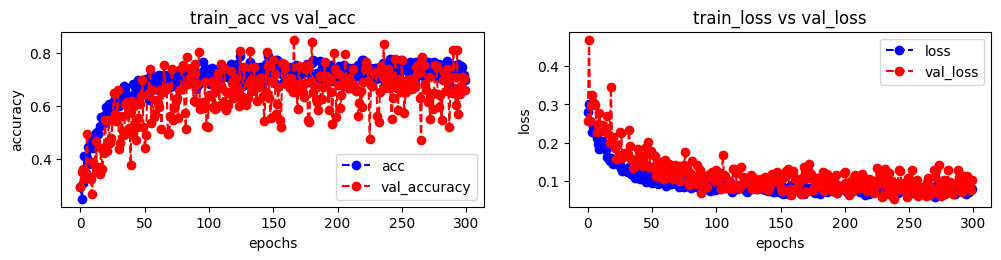

In [17]:
######################################################################    
################## Plotting accuracy and loss graph ##################    
###################################################################### 
def plot_accuracy_loss(history, name):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    
plot_accuracy_loss(history, "1")

In [ ]:
######################################################################    
############################ Saving model ############################    
######################################################################
model_name = "Best_model_so_far_abs_loss_function_RMSprop"
model.save("Models/{}.h5".format(model_name), save_format = 'h5')

# Experiments with automating the load of models

In [ ]:
######################################################################    
##################### Loading a model from a file ####################    
###################################################################### 
with CustomObjectScope({'abs_loss_function': square_abs_min_loss}):
    model = keras.models.load_model('Models/3db071e0968f11ed81960894ef90a55a_model_adam_001.h5')

In [ ]:
######################################################################    
###################### Define models as functions ####################    
###################################################################### 
def load_model_a():
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(3)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def load_model_b():
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = layers.Conv2D(filters=16, kernel_size=11, activation="relu")(inputs)
    x = layers.Conv2D(filters=16, kernel_size=7, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=5, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(3)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def load_model_c():
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = layers.Conv2D(filters=16, kernel_size=11, activation="relu")(inputs)
    x = layers.Conv2D(filters=16, kernel_size=7, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=5, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x) 
    outputs = layers.Dense(3)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()

def load_and_train_model(model, epochs = 100, loss_func = abs_loss_function):
    tg = datagenerator(32, (input_size,input_size), train_df, 1, 3)
    vg = datagenerator(32, (input_size,input_size), valid_df, 1, 3)
    model.compile(optimizer = RMSprop(learning_rate=0.001),
                  loss = loss_func, 
                  metrics = ["accuracy", loss_func])  # Add run_eagerly=True to enable the numpy debugging
    
    history = model.fit(x=tg,
                        batch_size=32,
                        epochs=epochs,
                        validation_data=vg)
    
    
    plot_accuracy_loss(history)
    return history

In [ ]:
######################################################################    
################# Loading models and tunning them ####################    
######################################################################
model_a = load_model_a()
model_a.summary()
history_a = load_and_train_model(model_a, 100, abs_loss_function)
model_b = load_model_b()
model_b.summary()
history_b = load_and_train_model(model_a, 100, abs_loss_function)
model_c = load_model_c()
model_c.summary()
history_c = load_and_train_model(model_c, 100, abs_loss_function)
plot_accuracy_loss(history_a)
plot_accuracy_loss(history_b)
plot_accuracy_loss(history_c)